# Statistická práce

## Použitá data

Jako dataset používám dataset "ilc_di08" z Eurostatu, který obsahuje informace o mediánovém a průměrném ročním příjmu v závislosti na:
- zemi (evropské státy)
- roce (2005 - 2023)
- úrovni vzdělání (ED0-2, ED3-4, ED5-8 podle ISCED)
- věkové skupině (plánuji se zaměřit na 18–64 let)
- pohlaví

### Přehled dat

Státy:
- `CZ` - Česká republika
- `DE` - Německo
- `EU` - Evropa, průměr
- `UK` - Velká Británie
- `CH` - Švýčarsko
- `RS` - Srbsko
- `HU` - Maďarsko
- atd.

Úrovně vzdělání:
- `ED0-2` - Early childhood education - Lower secondary education
- `ED3_4` - Upper secondary education - Post-secondary non-tertiary education
- `ED5-8` - Short-cycle tertiary education - Doctoral or equivalent level

Věkové skupiny:
- `Y18-64` - od 18 do 64 let
- `Y_GE18` - od 18 let
- `Y_GE65` - od 65 let

Pohlaví:
- `F` - ženy
- `M` - muži
- `T` - všichni

Příjem:
- `MED_E` - průměrný
- `MEI_E` - mediánový

Měny:
- `EUR` - eura
- `NAC` - měna zemi
- `PPS` - pps

## Popis zadání

Chtěl bych zjistit, jak silně koreluje úroveň vzdělání s příjmem v různých zemích (např. Česko, Německo, EU průměr) a jak se tato korelace vyvíjí v čase.

Plánovaná metodologie: Lineární regrese.

Také bych chtěl otestovat hypotézu, zda výše vzdělání hraje v příjmu větší roli v bohatších částech Evropy (např., Německo, Svýčarsko a Dansko), než v chudších částech Evropy (např., Maďarsko, Srbsko a Česká republika).

## Knihovny

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
import warnings

## Read data

In [2]:
df = pd.read_csv("../data/estat_ilc_di08.tsv", sep="\t", na_values=": ")

## Lineární regrese

### Metodologie lineární regrese

Nejprve upravíme data, aby každý řádek obsahoval číselnou úroveň vzdělání (1–3) a rok. Pak použijeme lineární regresi, která najde nejlepší přímku popisující vztah mezi těmito dvěma proměnnými a průměrným příjmem.

Koeficienty regresi říkají:
- kolik EUR navíc dostane člověk při posunu na vyšší úroveň vzdělání
- o kolik EUR se změní průměrný příjem za každý rok

To je hlavní myšlenka: model ukáže, jak moc na příjem působí vzdělání a jak se příjem mění v čase.


### Common

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

education_mapping = {
    "ED0-2": 1,
    "ED3_4": 2,
    "ED5-8": 3,
}

def do_statistics(country, country_code):
    # list of row identifiers
    keys = [
        f"A,MEI_E,EUR,ED0-2,T,Y18-64,{country_code}",
        f"A,MEI_E,EUR,ED3_4,T,Y18-64,{country_code}",
        f"A,MEI_E,EUR,ED5-8,T,Y18-64,{country_code}",
    ]

    first_col = df.columns[0]

    # filter dataframe for these first-column values
    df_filtered = df[df[first_col].isin(keys)]

    df_filtered = df_filtered.copy()
    df_filtered[first_col] = df_filtered[first_col].str.split(",").str[3].map(education_mapping)
    df_filtered.rename(columns={first_col: "education"}, inplace=True)

    df_triples = df_filtered.melt(id_vars="education", var_name="year", value_name="value").dropna(subset=["value"])

    # convert year and value to integers
    df_triples["year"] = df_triples["year"].astype(int)
    df_triples["value"] = df_triples["value"].map(lambda x: x.split()[0]).astype(int)

    # prepare feature matrix x and target vector y as integer arrays
    x = df_triples[["education", "year"]].values
    y = df_triples["value"].values

    model = LinearRegression(n_jobs=-1).fit(x, y)
    print(f"Coefficients (Education level, Year): {model.coef_}")

    # 1. Predicted vs actual average salary
    min_val = df_triples["value"].min()
    max_val = df_triples["value"].max()
    plt.figure(figsize=(14, 8))
    for edu in sorted(df_triples["education"].unique()):
        df_edu = df_triples[df_triples["education"] == edu]
        x_edu = df_edu[["year"]].values
        y_edu = df_edu["value"].values
        model_edu = LinearRegression(n_jobs=-1).fit(x_edu, y_edu)
        y_pred_edu = model_edu.predict(x_edu)
        print(f"Coefficients (Year) for Education level {edu}: {model_edu.coef_}")
        plt.scatter(y_edu, y_pred_edu, label=f"Education - {edu}")
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect Fit")
    plt.xlabel("Actual salary, EUR")
    plt.ylabel("Predicted salary, EUR")
    plt.title(f"Regression: Actual vs Predicted Salaries by Education Level, {country}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Average salary over years for each education level
    df_avg = df_triples.groupby(["year", "education"])["value"].first().unstack("education")
    plt.figure(figsize=(14, 8))
    for edu in df_avg.columns:
        plt.plot(df_avg.index, df_avg[edu], marker="o", label=f"Education - {edu}")
    plt.xlabel("Year")
    plt.ylabel("Average salary, EUR")
    plt.title(f"Average salary by Year and Education level, {country}")
    plt.legend()
    plt.xticks(df_avg.index)
    plt.grid(True)
    plt.show()

    # 3. Predict next 5 years salary for each education level
    max_year = df_triples["year"].max()
    future_years = list(range(max_year + 1, max_year + 6))
    plt.figure(figsize=(14, 8))
    for edu in df_avg.columns:
        preds = model.predict(np.array([[edu, yr] for yr in future_years]))
        plt.plot(future_years, preds, linestyle="--", marker="x", label=f"Education - {edu}")
    plt.xlabel("Year")
    plt.ylabel("Average salary, EUR")
    plt.title(f"Prediction of average salary, {country}")
    plt.xticks(future_years)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Check linear regression assumptions

    # 1. Residual normality test (Shapiro-Wilk)
    resid = y - model.predict(x)
    normality = pg.normality(resid, method='shapiro')
    print("Shapiro-Wilk test:", normality)

    # 2. Homoskedasticity test (Levene's test by education level)
    homo = pg.homoscedasticity(df_triples, dv='value', group='education', method='levene')
    print("Levene homoskedasticity test:", homo)

    # 3. Multicollinearity check (VIF)
    features = pd.DataFrame(x, columns=['education', 'year'])
    vif_data = pd.DataFrame({
        'feature': features.columns,
        'VIF': [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    })
    print("VIF:", vif_data)

    # Evaluate test results
    if normality['pval'][0] >= 0.05:
        print("✅ Residuals appear normal (p >= 0.05)")
    else:
        print("⚠️ Warning: residuals not normal (p < 0.05)")

    if homo['pval'][0] >= 0.05:
        print("✅ Homoskedasticity OK (p >= 0.05)")
    else:
        print("⚠️ Warning: heteroskedasticity (p < 0.05)")

    if (vif_data['VIF'] < 5).all():
        print("✅ Low multicollinearity (VIF < 5)")
    else:
        print("⚠️ Warning: high multicollinearity (VIF >= 5)")

### Interpretace koeficientů a ověření předpokladů

Po natrénování společného modelu (v závislosti na `education` a `year`) budeme interpretovat koeficienty:
- Koeficient pro `education` udává, o kolik EUR se v průměru změní roční příjem při zvýšení úrovně vzdělání o jednu úroveň
- Koeficient pro `year` udává trend růstu příjmu v EUR za každý rok

Ověření předpokladů:
1. Analýza reziduí: Shapiro-Wilk test
2. Test homoskedasticity: Levene homoskedasticity test
3. Kontrola multikolinearity: vypočteme VIF (Variance Inflation Factor) mezi proměnnými

### Česká republika

Coefficients (Education level, Year): [2805.125       495.13834586]
Coefficients (Year) for Education level 1: [389.16842105]
Coefficients (Year) for Education level 2: [496.07593985]
Coefficients (Year) for Education level 3: [600.17067669]


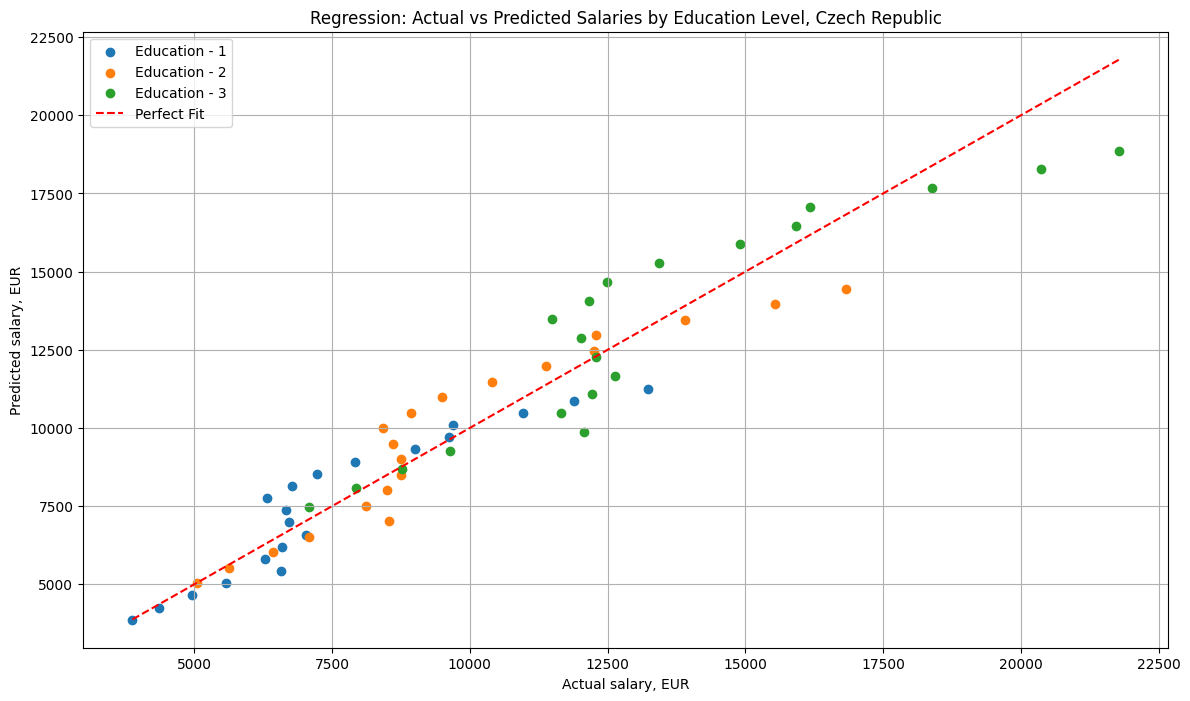

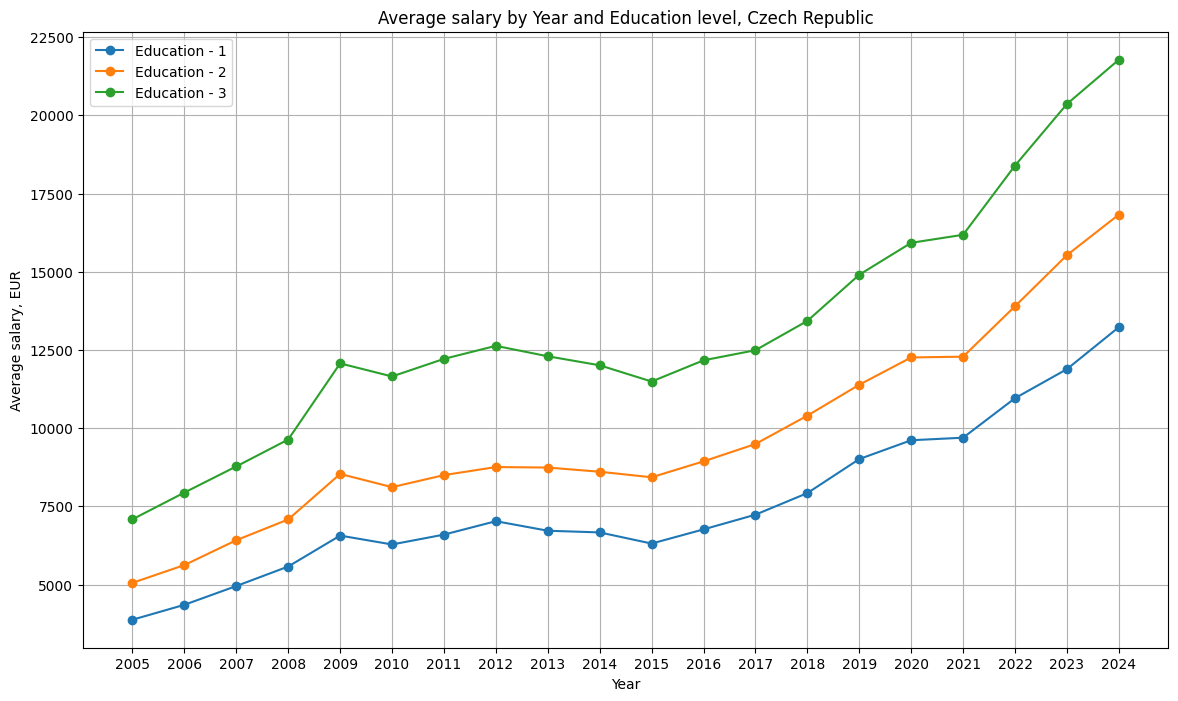

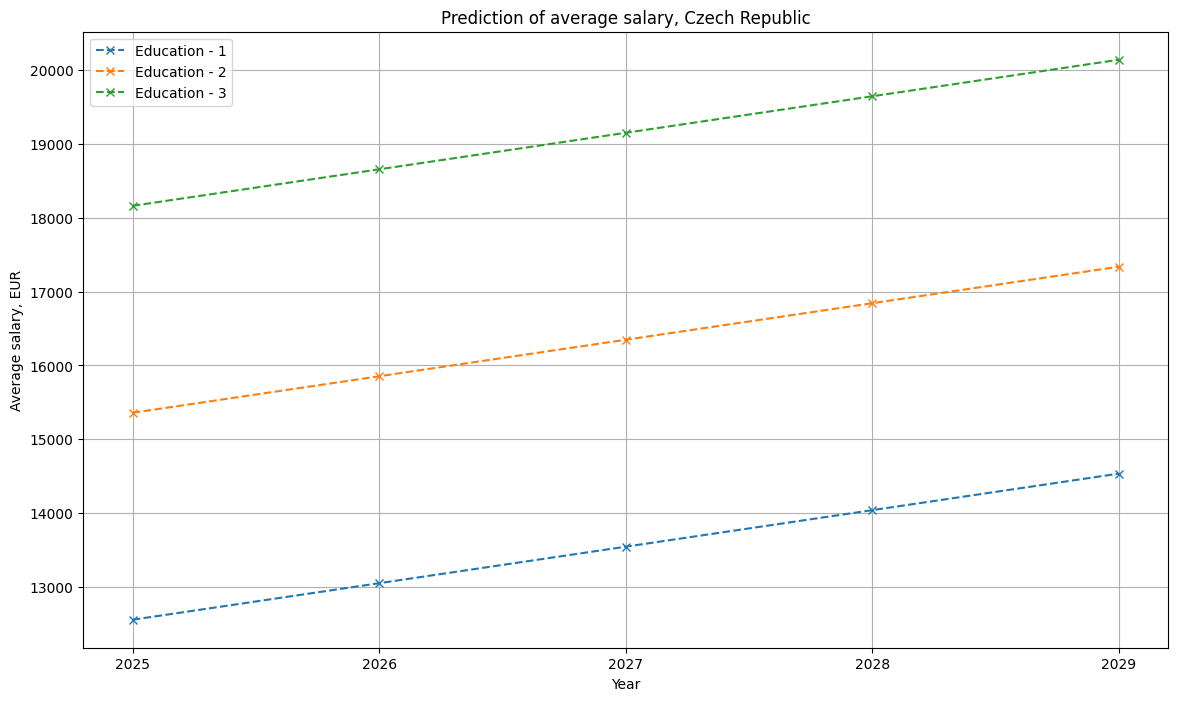

Shapiro-Wilk test:          W     pval  normal
0  0.95423  0.02473   False
Levene homoskedasticity test:                W      pval  equal_var
levene  0.700697  0.500463       True
VIF:      feature       VIF
0  education  6.999656
1       year  6.999656
⚠️ Warning: residuals not normal (p < 0.05)
✅ Homoskedasticity OK (p >= 0.05)
⚠️ Warning: high multicollinearity (VIF >= 5)


In [4]:
do_statistics("Czech Republic", "CZ")

### Německo

Coefficients (Education level, Year): [6286.7         646.94285714]
Coefficients (Year) for Education level 1: [404.23233083]
Coefficients (Year) for Education level 2: [624.27368421]
Coefficients (Year) for Education level 3: [912.32255639]


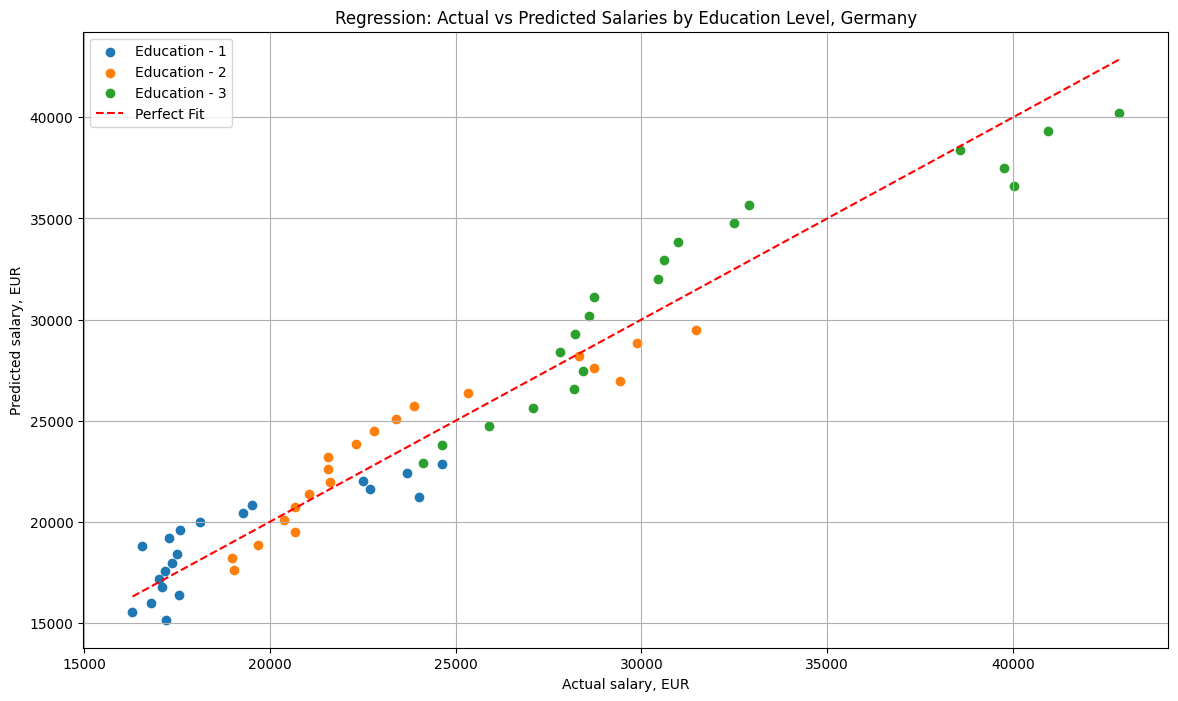

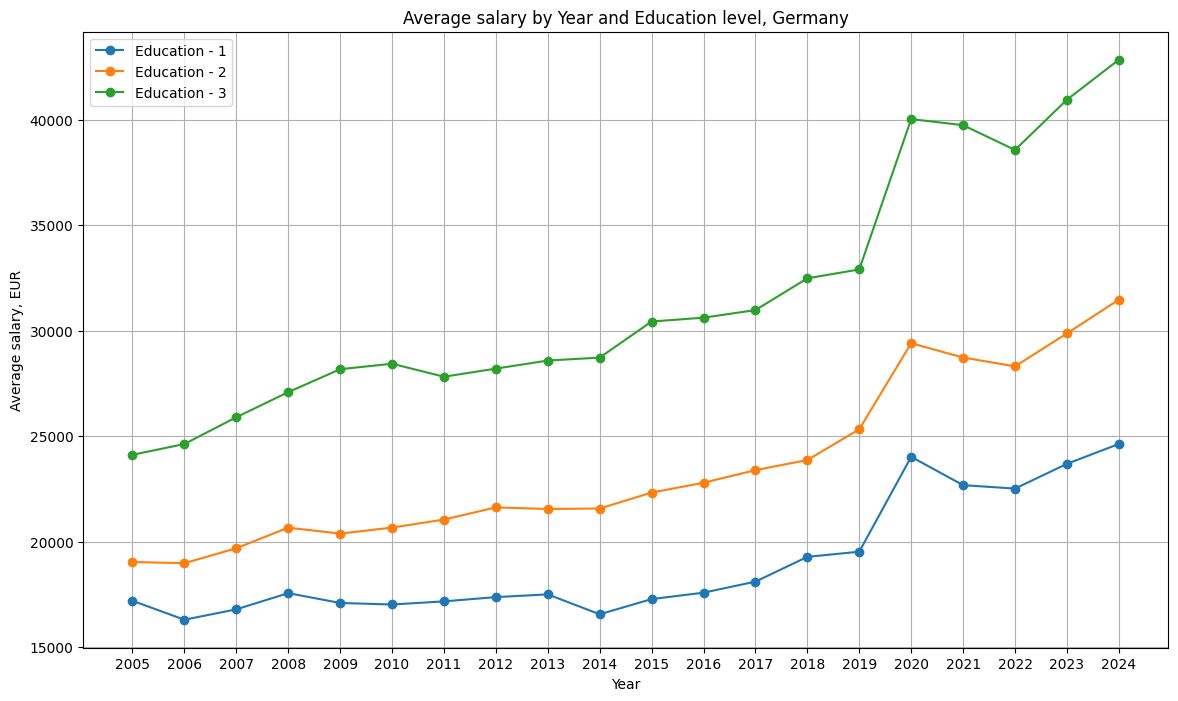

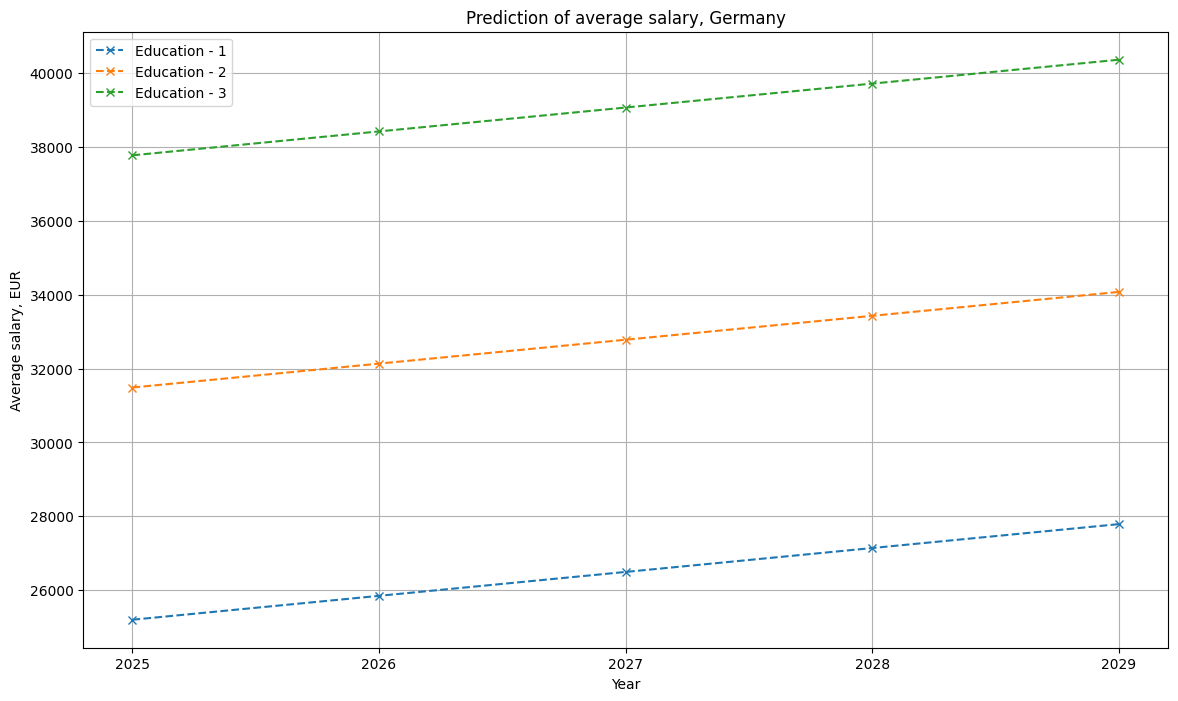

Shapiro-Wilk test:          W      pval  normal
0  0.90395  0.000184   False
Levene homoskedasticity test:                W      pval  equal_var
levene  2.843276  0.066522       True
VIF:      feature       VIF
0  education  6.999656
1       year  6.999656
⚠️ Warning: residuals not normal (p < 0.05)
✅ Homoskedasticity OK (p >= 0.05)
⚠️ Warning: high multicollinearity (VIF >= 5)


In [5]:
do_statistics("Germany", "DE")

### Evropa

Coefficients (Education level, Year): [5629.3         502.41904762]
Coefficients (Year) for Education level 1: [353.04285714]
Coefficients (Year) for Education level 2: [495.24642857]
Coefficients (Year) for Education level 3: [658.96785714]


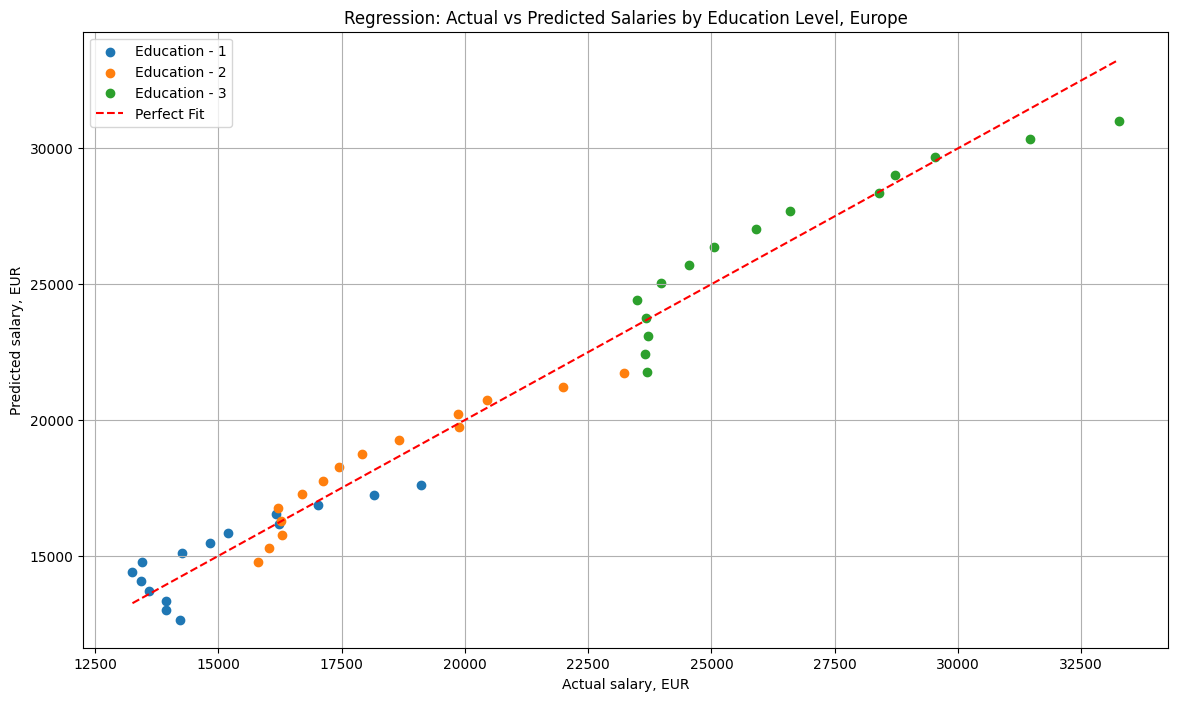

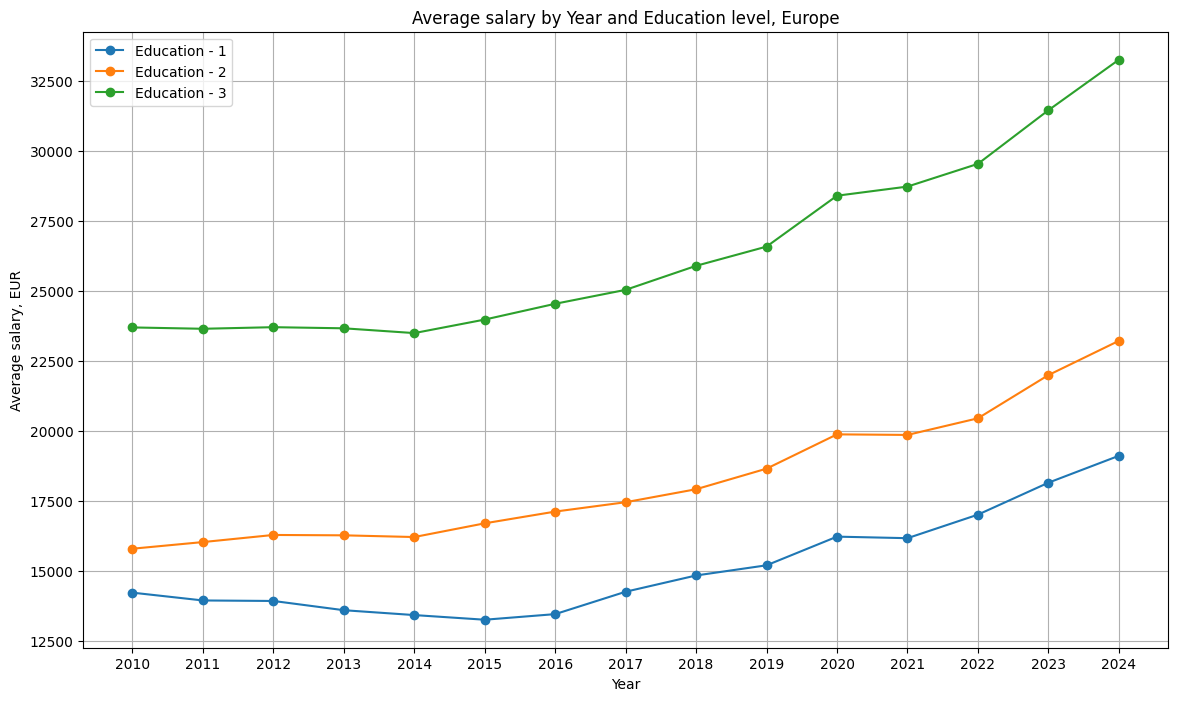

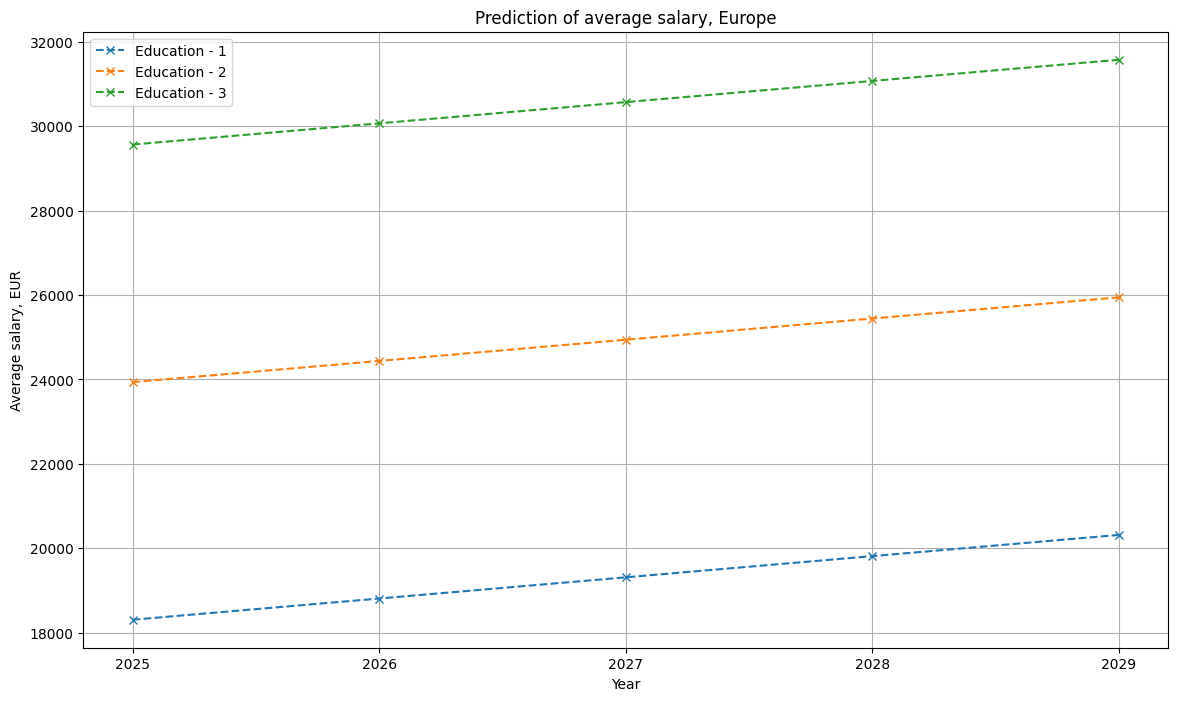

Shapiro-Wilk test:           W      pval  normal
0  0.963063  0.159752    True
Levene homoskedasticity test:               W      pval  equal_var
levene  1.33063  0.275223       True
VIF:      feature       VIF
0  education  6.999807
1       year  6.999807
✅ Residuals appear normal (p >= 0.05)
✅ Homoskedasticity OK (p >= 0.05)
⚠️ Warning: high multicollinearity (VIF >= 5)


In [6]:
do_statistics("Europe", "EU27_2020")

### Výsledek

Je očividný z obrázků (a intuitivně), že příjem je v průměru vyšší pro lidi s vyšším vzděláním bez ohledu na stát nebo rok.

Lineární regrese nebyla úspěšná, protože nebyli splněny některé z předpokladů. To odpovídá realitě, protože ekonomický stav státu závisí na hromadě faktorů a tím nemůže být úplně stabilní, i když v průměru se zlepšuje v čase.
Na druhou stranu regrese není tak špatná a může dávat přehled na rozvoj mezd.

## Testování hypotézy

Za reprezentanty bohatší části Evropy zvolíme Německo, Dansko, Švýcarsko, Vélkou Británii a Francii.

Za reprezentanty chydší části Evropy zvolíme Česko, Maďarsko, Srbsko, Bulharsko a Litvu.

Hypotéza: průměrný faktor (příjem s vyšším / příjem se středním vzděláním) pro bohatší a chydší části Evropy se nelíší.

t-statistic: -24.54213293574314
p-value: 6.549162841569821e-25
Coefficients (Year, Education): [0.00074355 0.20194621]


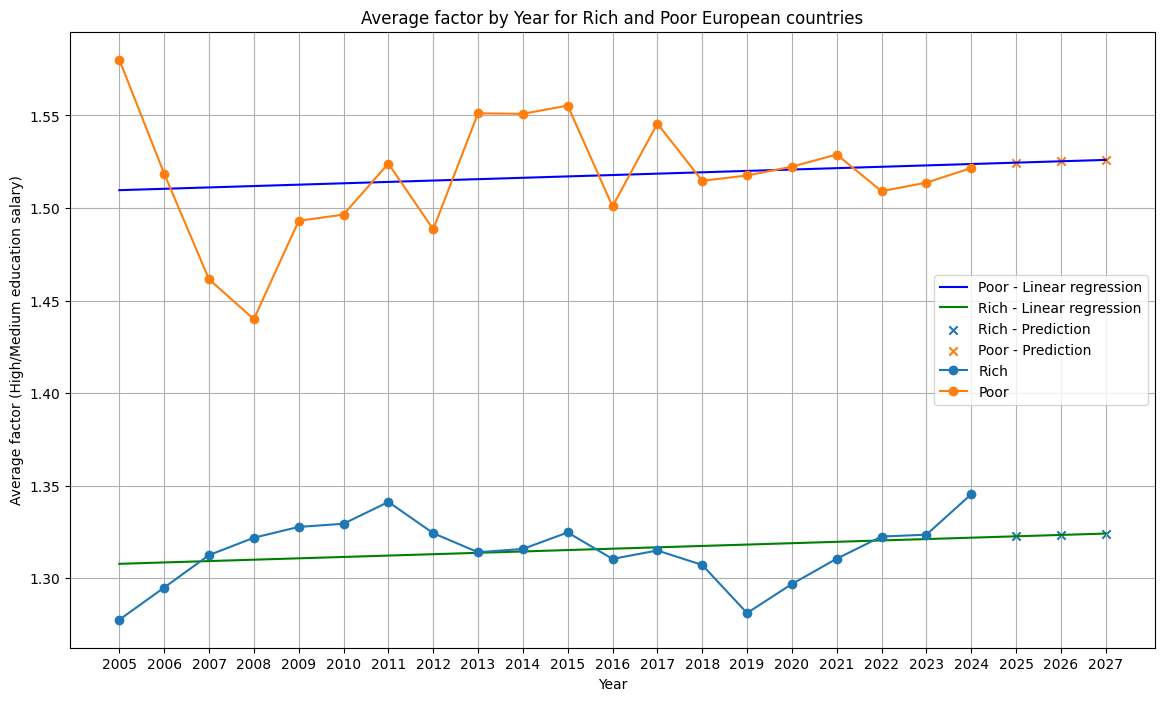

In [7]:
warnings.filterwarnings("ignore", category=UserWarning)

rich_countries = ["DE", "DK", "CH", "UK", "FR"]
poor_countries = ["CZ", "HU", "RS", "BG", "LT"]

def do_statistics_2(countries):
    first_col = df.columns[0]
    records = []
    for country_code in countries:
        # list of row identifiers
        keys = [
            f"A,MEI_E,EUR,ED0-2,T,Y18-64,{country_code}",
            f"A,MEI_E,EUR,ED3_4,T,Y18-64,{country_code}",
            f"A,MEI_E,EUR,ED5-8,T,Y18-64,{country_code}",
        ]

        df_filtered = df[df[first_col].isin(keys)]

        df_filtered = df_filtered.copy()
        df_filtered[first_col] = df_filtered[first_col].str.split(",").str[3].map(education_mapping)
        df_filtered.rename(columns={first_col: "education"}, inplace=True)

        df_triples = df_filtered.melt(id_vars="education", var_name="year", value_name="value").dropna(subset=["value"])

        # convert year and value to integers
        df_triples["year"] = df_triples["year"].astype(int)
        df_triples["value"] = df_triples["value"].map(lambda x: x.split()[0]).astype(int)

        # average salary per year and education
        df_avg = df_triples.groupby(["year", "education"])["value"].mean().unstack()

        # compute factor = high education / medium education
        df_avg = df_avg.loc[:, [2, 3]].dropna()
        df_avg["factor"] = df_avg[3] / df_avg[2]
        df_avg = df_avg.reset_index()[["year", "factor"]]
        df_avg["country"] = country_code
        
        records.append(df_avg)

    df_factors = pd.concat(records, ignore_index=True)
    return df_factors.groupby("year")["factor"].mean().reset_index()

rich_factors = do_statistics_2(rich_countries)[2:]
poor_factors = do_statistics_2(poor_countries)

# Independent two-sample t-test
t_stat, p_value = ttest_ind(rich_factors["factor"], poor_factors["factor"])

print("t-statistic:", t_stat)
print("p-value:", p_value)

rich_factors["group"] = 0
poor_factors["group"] = 1
summary = pd.concat([rich_factors, poor_factors], ignore_index=True)

X = summary[["year", "group"]].values
y = summary["factor"].values

model = LinearRegression(n_jobs=-1).fit(X, y)

print("Coefficients (Year, Education):", model.coef_)

years = np.array(sorted(summary["year"].unique()) + list(range(2025, 2028)))

plt.figure(figsize=(14, 8))

# Predict for Poor group
poor_X = pd.DataFrame({"year": years, "group": 1})
poor_pred = model.predict(poor_X)
plt.plot(years, poor_pred, label="Poor - Linear regression", color="blue")

# Predict for Rich group
rich_X = pd.DataFrame({"year": years, "group_code": 0})
rich_pred = model.predict(rich_X)
plt.plot(years, rich_pred, label="Rich - Linear regression", color="green")

plt.scatter(list(range(2025, 2028)), rich_pred[-3:], marker="x", label="Rich - Prediction")
plt.scatter(list(range(2025, 2028)), poor_pred[-3:], marker="x", label="Poor - Prediction")

plt.plot(rich_factors["year"], rich_factors["factor"], marker="o", label="Rich")
plt.plot(poor_factors["year"], poor_factors["factor"], marker="o", label="Poor")
plt.xlabel("Year")
plt.ylabel("Average factor (High/Medium education salary)")
plt.title("Average factor by Year for Rich and Poor European countries")
plt.legend()
plt.grid(True)
plt.xticks(years)
plt.show()


Pro ověření, zda vliv vzdělání (poměr průměrné mzdy vysoce vzdělaných k středně vzdělaným) skutečně závisí na bohatství země:

1. Vypočítáme pro každou z vybraných skupin zemí roční faktor:
   - `factor` = průměrný příjem (úroveň ED5-8) / průměrný příjem (úroveň ED3-4)
2. Skupiny:
   - `rich_countries`: bohaté státy (DE, DK, CH, UK, FR)
   - `poor_countries`: chudé státy (CZ, HU, RS, BG, LT)
3. Nejprve provedeme nezávislý t-test (two-sample t-test) na porovnání průměrných faktorů mezi skupinami:
   - Předpoklady: nezávislost vzorků, přibližná normalita faktorů v každé skupině
4. Dále postavíme lineární regresi s vysvětlovacími proměnnými `year` a binární proměnnou `group` (0 = bohatí, 1 = chudí) na vysvětlování hodnoty `factor`
   - Koeficient u `group` nám ukáže průměrný rozdíl faktorů mezi chudými a bohatými státy
   - Koeficient u `year` zachycuje časový trend změny faktoru

T-test ukazuje, že hypotézu máme zamitnout ($p$ hodnota je extrémně malá), tedy z toho plyne (a je zřejmý z obrázku nahoře) že vzdělání má větší vliv na příjem v chydších státech Evropy než v bohatších.

## Závěry a omezení

**Závěry**
- Výše vzdělání významně ovlivňuje příjem v evropských zemích
- Vliv vzdělání je silnější v chudších zemích (CZ, HU, RS, BG, LT) než v bohatších (DE, DK, CH, UK, FR)
- Nejde udělat dobrou lineární regresi, protože rozvoj ekomomiky nejde jednoduše odhadovat, alespoň nejde to lineárně

**Omezení**
- Nepřihlížel jsem k dalším faktorům (např. pohlaví)
- Lineární model může ignorovat možné nelineární vztahy